Advanced features 1)Token features cwc-min=common words/min(words(q1,q2)) cwc-max=common words/max(words(q1,q2)) csc-min= no.of common stop words/min(stop words(q1,q2)) csc-max=no.of common stop words/max(stop words(q1,q2)) ctc-min=common token/min(token(q1,q2)) ctc-max=common token/max(token(q1,q2)) last-word-equal= first word-equal 2)Length based features mean length abs-len-diff longest-substr-ratio 3)Fuzzy features fuzz ratio fuzz partial ratio token sort ratio token set ratio

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('train.csv')

In [4]:
new_df = df.sample(30000,random_state=2)

In [5]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1
115086,115086,187729,187730,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0
327711,327711,454161,454162,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0
367788,367788,498109,491396,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0
151235,151235,237843,50930,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0


In [6]:

import re
from bs4 import BeautifulSoup

def preprocess(q):
    q = str(q).lower().strip()

    # Replace certain special characters with their string equivalents
    q = q.replace('%', 'percent')
    q = q.replace('$', 'dollar')
    q = q.replace('₹', 'rupee')
    q = q.replace('€', 'euro')
    q = q.replace('@', 'at')

    # The pattern '[math]' appears around 900 times in the whole dataset
    q = q.replace('[math]', '')

    # Replacing some numbers with string equivalents
    q = q.replace(',000,000,000 ', 'b')
    q = q.replace(',000,000', 'm')
    q = q.replace(',000', 'k')

    # Use re.sub() for replacing numbers followed by zeros
    q = re.sub(r'([0-9]+)000000000', r'\\lb', q)
    q = re.sub(r'([0-9]+)000000', r'\\lm', q)
    q = re.sub(r'([0-9]+)000', r'\\lk', q)

    contractions = {
        "a’ight": "alright", "ain’t": "am not / is not / are not / has not / have not / did not",
        "amn’t": "am not", "’n’": "and", "arencha": "are not you / aren't you", "aren’t": "are not",
        "’bout": "about", "can’t": "cannot", "cap’n": "captain", "’cause": "because", "cuz": "because",
        "’cept": "except", "c’mon": "come on", "could’ve": "could have", "couldn’t": "could not",
        "couldn’t’ve": "could not have", "cuppa": "cup of", "daren’t": "dare not / dared not",
        "daresn’t": "dare not", "dasn’t": "dare not", "didn’t": "did not", "doesn't": "does not",
        "don’t": "do not / does not", "dunno": "do not know / don't know", "d’ye": "do you / did you",
        "d’ya": "do you / did you", "e’en": "even", "e’er": "ever", "’em": "them", "everybody’s": "everybody has / everybody is",
        "everyone’s": "everyone has / everyone is", "everything's": "everything has / everything is",
        "finna": "fixing to", "fo’c’sle": "forecastle", "’gainst": "against", "g’day": "good day", "gimme": "give me",
        "giv’n": "given", "gi’z": "give us", "gonna": "going to", "gon’t": "go not", "gotta": "got to",
        "hadn’t": "had not", "had’ve": "had have", "hasn’t": "has not", "haven’t": "have not", "he’d": "he had / he would",
        "he'll": "he shall / he will", "helluva": "hell of a", "yesn't": "yes not / no", "he’s": "he has / he is",
        "here’s": "here is", "how’d": "how did / how would", "howdy": "how do you do / how do you fare",
        "how’ll": "how will / how shall", "how’re": "how are", "how’s": "how has / how is / how does", "I’d": "I had / I would",
        "I’ve": "I have", "I’m": "I am", "I’ll": "I shall / I will", "I’m'onna": "I am going to", "I’m’o": "I am going to",
        "I’m'na": "I am going to", "inn’t": "isn’t it", "Ion": "I do not / I don't", "isn’t": "is not", "it’s": "it has / it is",
        "Idunno": "I do not know", "kinda": "kind of", "lemme": "let me", "let’s": "let us", "loven’t": "love not",
        "mayn’t": "may not", "may’ve": "may have", "methinks": "I think", "mightn’t": "might not", "might’ve": "might have",
        "mine’s": "mine is", "mustn’t": "must not", "must’ve": "must have", "’neath": "beneath", "needn’t": "need not",
        "nal": "and all", "ne’er": "never", "no one's": "no one has / no one is", "o’clock": "of the clock", "o’er": "over",
        "ol’": "old", "ought’ve": "ought have", "oughtn’t": "ought not", "’round": "around", "’s": "is, has, does, us / possessive",
        "shalln’t": "shall not", "shan’": "shall not", "shan’t": "shall not", "she’d": "she had / she would", "she’ll": "she shall / she will",
        "she’s": "she has / she is", "should’ve": "should have", "shouldn’t": "should not", "shouldn’t’ve": "should not have",
        "somebody’s": "somebody has / somebody is", "someone’s": "someone has / someone is", "something’s": "something has / something is",
        "so’re": "so are", "so’s": "so is / so has", "that’ll": "that shall / that will", "that’s": "that has / that is",
        "there’s": "there has / there is", "these’re": "these are", "these’ve": "these have", "they’d": "they had / they would",
        "they’ll": "they shall / they will", "they’re": "they are / they were", "they’ve": "they have", "this’s": "this has / this is",
        "those’re": "those are", "’thout": "without", "’til": "until", "’tis": "it is", "to’ve": "to have", "tryna": "trying to",
        "’twas": "it was", "’tween": "between", "’twere": "it were", "w’all": "we all", "w’at": "we at", "wanna": "want to",
        "wasn’t": "was not", "we’d": "we had / we would / we did", "we’ll": "we shall / we will", "we’re": "we are", "we’ve": "we have",
        "weren’t": "were not", "whatcha": "what are you", "what’d": "what did", "what’ll": "what shall / what will",
        "what’s": "what has / what is / what does", "what’ve": "what have", "where’d": "where did", "where’s": "where has / where is / where does",
        "willn’t": "will not", "won’t": "will not", "would’ve": "would have", "wouldn’t": "would not", "y’all": "you all",
        "you’re": "you are", "you’ve": "you have"
    }

    # Handle contractions
    q_decontracted = []
    for word in q.split():
        if word in contractions:
            word = contractions[word]
        q_decontracted.append(word)

    q = ' '.join(q_decontracted)

    # Fix common contractions
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")

    # Remove HTML tags
    q = BeautifulSoup(q, "html.parser").get_text()

    # Remove non-alphabetical characters (punctuation)
    q = re.sub(r'[^a-zA-Z\s]', '', q).strip()

    return q

# Test the function
result = preprocess("I've already! wasn't <b>done</b>?")
print(result)


i have already was not done


In [7]:
preprocess("I've already! wasn't <b>done</b>?")

'i have already was not done'

In [8]:
new_df['question1'] = new_df['question1'].apply(preprocess)
new_df['question2'] = new_df['question2'].apply(preprocess)

In [9]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wha...,0
327711,327711,454161,454162,i am from india and live abroad i met a guy fr...,tiet to thapar university to thapar university...,0
367788,367788,498109,491396,why do so many people in the us hate the south...,my boyfriend doesnt feel guilty when he hurts ...,0
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0


In [10]:
new_df['q1_len'] = new_df['question1'].str.len()
new_df['q2_len'] = new_df['question2'].str.len()

In [11]:
new_df['q1_num_words'] = new_df['question1'].apply(lambda row: len(row.split(" ")))
new_df['q2_num_words'] = new_df['question2'].apply(lambda row: len(row.split(" ")))
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,74,75,12,12
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wha...,0,47,55,12,15
327711,327711,454161,454162,i am from india and live abroad i met a guy fr...,tiet to thapar university to thapar university...,0,101,115,25,17
367788,367788,498109,491396,why do so many people in the us hate the south...,my boyfriend doesnt feel guilty when he hurts ...,0,56,143,12,30
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9


In [12]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(),row['question1'].split(" ")))
    w2 = set(map(lambda word:word.lower().strip(),row['question2'].split(" ")))
    return len(w1 & w2)

In [13]:
new_df['word_common'] = new_df.apply(common_words,axis=1)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,74,75,12,12,11
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wha...,0,47,55,12,15,7
327711,327711,454161,454162,i am from india and live abroad i met a guy fr...,tiet to thapar university to thapar university...,0,101,115,25,17,2
367788,367788,498109,491396,why do so many people in the us hate the south...,my boyfriend doesnt feel guilty when he hurts ...,0,56,143,12,30,0
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3


In [14]:
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(),row['question1'].split(" ")))
    w2 = set(map(lambda word:word.lower().strip(),row['question2'].split(" ")))
    return (len(w1) + len( w2))
new_df['word_total'] = new_df.apply(total_words,axis=1)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,74,75,12,12,11,24
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wha...,0,47,55,12,15,7,22
327711,327711,454161,454162,i am from india and live abroad i met a guy fr...,tiet to thapar university to thapar university...,0,101,115,25,17,2,34
367788,367788,498109,491396,why do so many people in the us hate the south...,my boyfriend doesnt feel guilty when he hurts ...,0,56,143,12,30,0,31
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3,13


In [15]:
new_df['word_share'] = round(new_df['word_common']/new_df['word_total'],2)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,74,75,12,12,11,24,0.46
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wha...,0,47,55,12,15,7,22,0.32
327711,327711,454161,454162,i am from india and live abroad i met a guy fr...,tiet to thapar university to thapar university...,0,101,115,25,17,2,34,0.06
367788,367788,498109,491396,why do so many people in the us hate the south...,my boyfriend doesnt feel guilty when he hurts ...,0,56,143,12,30,0,31,0.00
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3,13,0.23


1)Token features cwc-min=common words/min(words(q1,q2)) cwc-max=common words/max(words(q1,q2)) csc-min= no.of common stop words/min(stop words(q1,q2)) csc-max=no.of common stop words/max(stop words(q1,q2)) ctc-min=common token/min(token(q1,q2)) ctc-max=common token/max(token(q1,q2)) last-word-equal= first word-equal

In [17]:
#advanced features
from nltk.corpus import stopwords

def fetch_token_features(row):
    q1 = row['question1']
    q2 = row['question2']

    SAFE_DIV = 0.0001  #added so that the denominator doesnt becomes 0

    STOP_WORDS = stopwords.words("english")

    token_features = [0.0]*8

    #Converting the sentence into tokens
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens)==0 or len(q2_tokens)==0:
        return token_features

    #Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

    #get the common non-stop words from question pair
    common_word_count = len(q1_words.intersection(q2_words))

    #Get the common stop words from question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))

    #Get the common tokens from question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

    token_features[0] = common_word_count/(min(len(q1_words),len(q2_words))+SAFE_DIV)
    token_features[1] = common_word_count/(max(len(q1_words),len(q2_words))+SAFE_DIV)
    token_features[2] = common_stop_count/(min(len(q1_stops),len(q2_stops))+SAFE_DIV)
    token_features[3] = common_stop_count/(max(len(q1_stops),len(q2_stops))+SAFE_DIV)
    token_features[4] = common_token_count/(min(len(q1_tokens),len(q2_tokens))+SAFE_DIV)
    token_features[5] = common_token_count/(max(len(q1_tokens),len(q2_tokens))+SAFE_DIV)

    #Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1]==q2_tokens[-1])

    #First word of both question is same or not
    token_features[7] = int(q1_tokens[0]==q2_tokens[0])

    return token_features

In [18]:
token_features = new_df.apply(fetch_token_features, axis=1)

new_df["cwc_min"] = list(map(lambda x:x[0], token_features))
new_df["cwc_max"] = list(map(lambda x:x[1], token_features))
new_df["csc_min"] = list(map(lambda x:x[2], token_features))
new_df["csc_max"] = list(map(lambda x:x[3], token_features))
new_df["ctc_min"] = list(map(lambda x:x[4], token_features))
new_df["ctc_max"] = list(map(lambda x:x[5], token_features))
new_df["last_word_eq"] = list(map(lambda x:x[6], token_features))
new_df["first_word_eq"] = list(map(lambda x:x[7], token_features))

In [19]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,word_total,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,74,75,12,12,...,24,0.46,0.857131,0.857131,0.999980,0.999980,0.916659,0.916659,1.0,1.0
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wha...,0,47,55,12,15,...,22,0.32,0.666644,0.499988,0.714276,0.624992,0.583328,0.466664,1.0,1.0
327711,327711,454161,454162,i am from india and live abroad i met a guy fr...,tiet to thapar university to thapar university...,0,101,115,25,17,...,34,0.06,0.000000,0.000000,0.399992,0.181817,0.117646,0.080000,0.0,0.0
367788,367788,498109,491396,why do so many people in the us hate the south...,my boyfriend doesnt feel guilty when he hurts ...,0,56,143,12,30,...,31,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,...,13,0.23,0.749981,0.599988,0.000000,0.000000,0.599988,0.333330,1.0,0.0


In [20]:
#length based features
import distance

def fetch_length_features(row):
    q1 = row['question1']
    q2 = row['question2']

    length_features = [0.0]*3

    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens)==0 or len(q2_tokens)==0:
        return length_features

    #Absolute Length features
    length_features[0]=abs(len(q1_tokens)-len(q2_tokens))
    #Average token length of both questions
    length_features[1] = (len(q1_tokens)+len(q2_tokens))/2

    strs = list(distance.lcsubstrings(q1,q2))
    length_features[2] =len(strs[0])/(min(len(q1),len(q2))+1)

    return length_features

                


In [21]:
length_features = new_df.apply(fetch_length_features,axis=1)

new_df['abs_len_diff']=list(map(lambda x:x[0],length_features))
new_df['mean_len']=list(map(lambda x:x[1],length_features))
new_df['longest_substr_ratio']=list(map(lambda x:x[2],length_features))

In [22]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,74,75,12,12,...,0.857131,0.999980,0.999980,0.916659,0.916659,1.0,1.0,0.0,12.0,0.853333
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wha...,0,47,55,12,15,...,0.499988,0.714276,0.624992,0.583328,0.466664,1.0,1.0,3.0,13.5,0.229167
327711,327711,454161,454162,i am from india and live abroad i met a guy fr...,tiet to thapar university to thapar university...,0,101,115,25,17,...,0.000000,0.399992,0.181817,0.117646,0.080000,0.0,0.0,8.0,21.0,0.049020
367788,367788,498109,491396,why do so many people in the us hate the south...,my boyfriend doesnt feel guilty when he hurts ...,0,56,143,12,30,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,18.0,21.0,0.052632
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,...,0.599988,0.000000,0.000000,0.599988,0.333330,1.0,0.0,4.0,7.0,0.542857


In [23]:
#fuzzy features
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):
    q1 = row['question1']
    q2 = row['question2']

    fuzzy_features = [0.0]*4

    #fuzz ratio
    fuzzy_features[0] = fuzz.QRatio(q1,q2)
    #fuzz partial ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1,q2)
    #token sort ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1,q2)
    #token set ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1,q2)

    return fuzzy_features

In [24]:
fuzzy_features = new_df.apply(fetch_fuzzy_features, axis=1)

#creating new fuzzy columns for fuzzy features
new_df['fuzz_ratio']=list(map(lambda x:x[0],fuzzy_features))
new_df['fuzz_partial_ratio']=list(map(lambda x:x[1],fuzzy_features))
new_df['fuzz_sort_ratio']=list(map(lambda x:x[2],fuzzy_features))
new_df['fuzz_set_ratio']=list(map(lambda x:x[3],fuzzy_features))

In [25]:
print(new_df.shape)
new_df.head()

(30000, 28)


,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,fuzz_sort_ratio,fuzz_set_ratio
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,74,75,12,12,...,0.916659,1.0,1.0,0.0,12.0,0.853333,99,99,99,99
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wha...,0,47,55,12,15,...,0.466664,1.0,1.0,3.0,13.5,0.229167,69,66,67,74
327711,327711,454161,454162,i am from india and live abroad i met a guy fr...,tiet to thapar university to thapar university...,0,101,115,25,17,...,0.080000,0.0,0.0,8.0,21.0,0.049020,42,42,39,44
367788,367788,498109,491396,why do so many people in the us hate the south...,my boyfriend doesnt feel guilty when he hurts ...,0,56,143,12,30,...,0.000000,0.0,0.0,18.0,21.0,0.052632,37,50,37,40
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,...,0.333330,1.0,0.0,4.0,7.0,0.542857,60,71,48,69


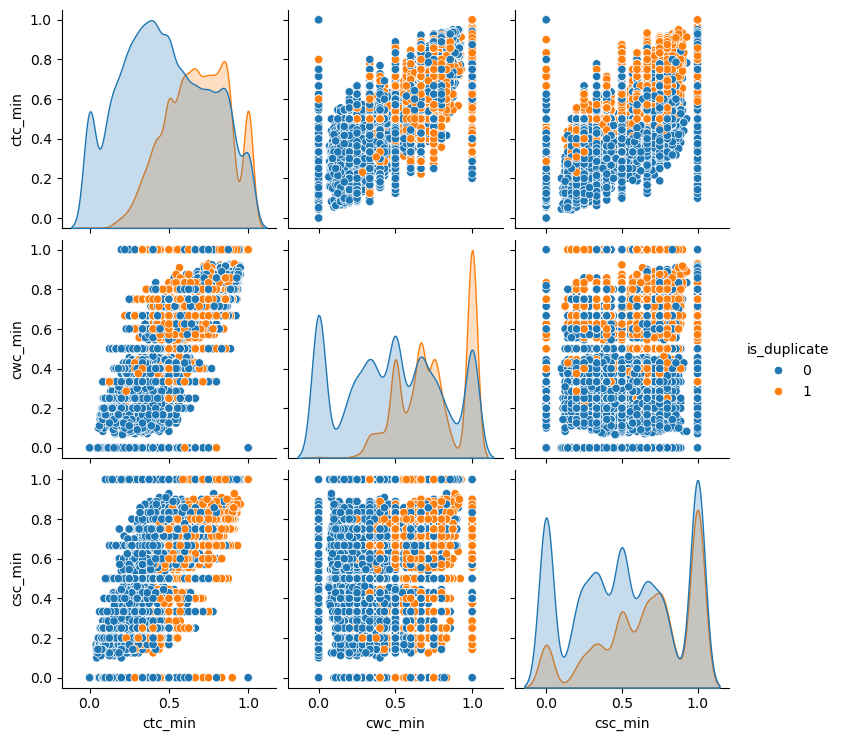

In [26]:
#EDA on new features whether they are helpful or not
sns.pairplot(new_df[['ctc_min','cwc_min','csc_min','is_duplicate']],hue='is_duplicate')


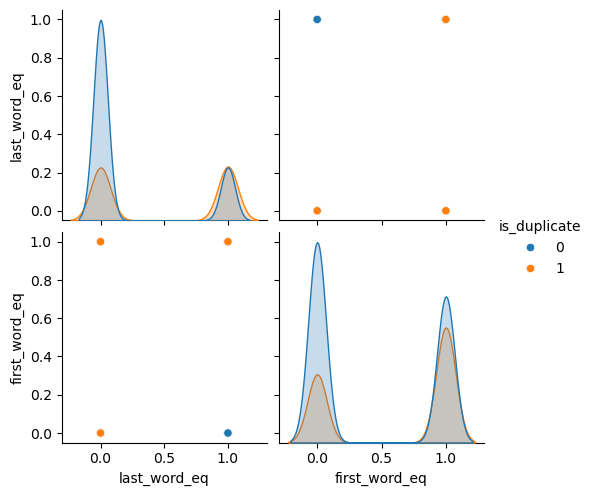

In [27]:
sns.pairplot(new_df[['last_word_eq','first_word_eq','is_duplicate']],hue='is_duplicate')

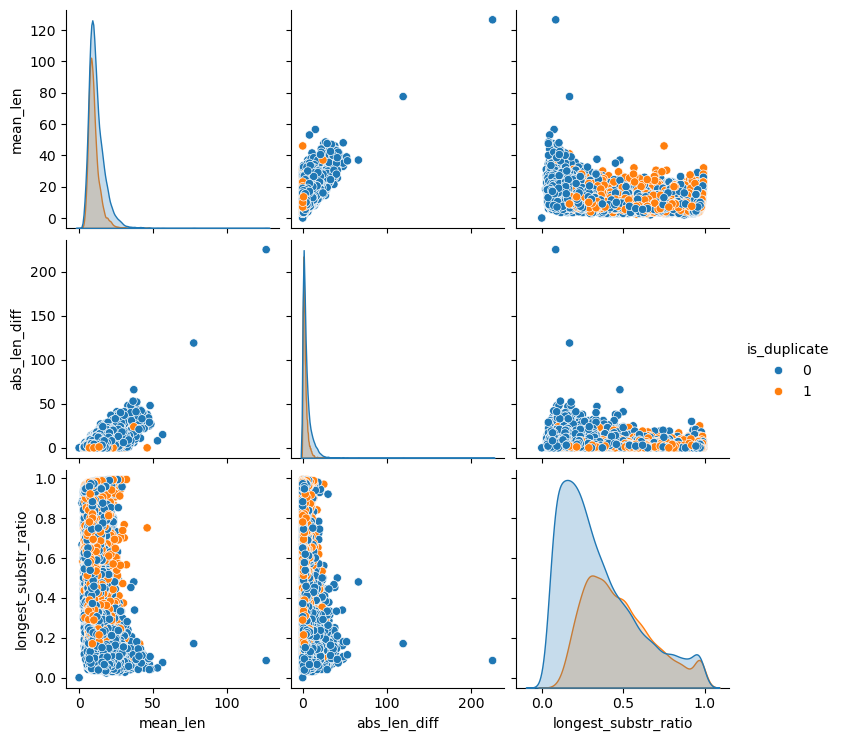

In [28]:
sns.pairplot(new_df[['mean_len','abs_len_diff','longest_substr_ratio','is_duplicate']],hue='is_duplicate')

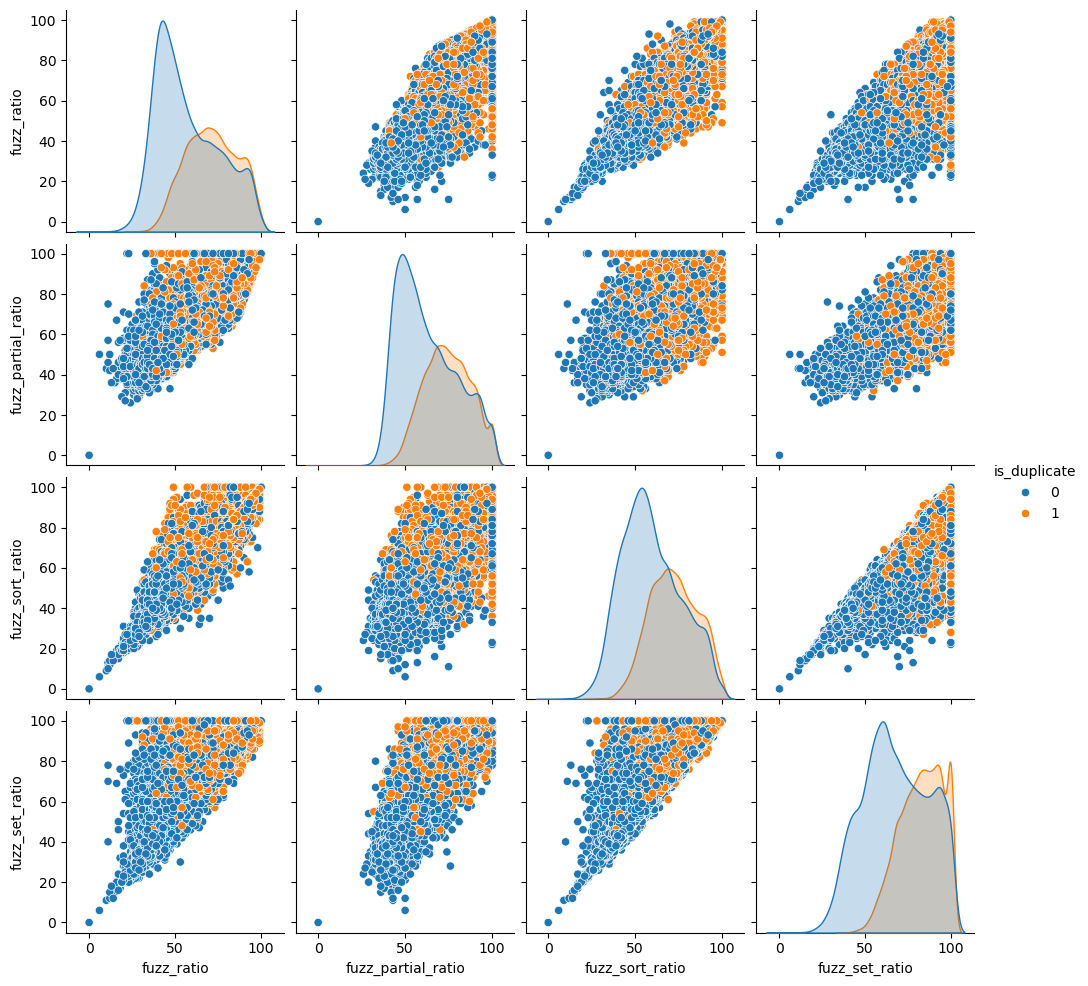

In [29]:
sns.pairplot(new_df[['fuzz_ratio', 'fuzz_partial_ratio', 'fuzz_sort_ratio', 'fuzz_set_ratio', 'is_duplicate']], hue='is_duplicate')


In [30]:
#Using TSNE for Dimensionality reduction for 15 features(Generated after cleaning the data) to 3 dimmension
from sklearn.preprocessing import MinMaxScaler

X = MinMaxScaler().fit_transform(new_df[['cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq']])
y=new_df['is_duplicate'].values

In [31]:
from sklearn.manifold import TSNE

tsne2d = TSNE(
    n_components=2,
    init='random',#pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30000 samples in 0.060s...
[t-SNE] Computed neighbors for 30000 samples in 3.704s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for sam

In [32]:
tsne3d = TSNE(
    n_components=3,
    init='random',
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30000 samples in 0.052s...
[t-SNE] Computed neighbors for 30000 samples in 3.641s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for sam

In [33]:
ques_df=new_df[['question1','question2']]
ques_df.head()

,question1,question2
398782,what is the best marketing automation tool for...,what is the best marketing automation tool for...
115086,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wha...
327711,i am from india and live abroad i met a guy fr...,tiet to thapar university to thapar university...
367788,why do so many people in the us hate the south...,my boyfriend doesnt feel guilty when he hurts ...
151235,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy


In [34]:
final_df=new_df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

(30000, 23)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,fuzz_sort_ratio,fuzz_set_ratio
398782,1,74,75,12,12,11,24,0.46,0.857131,0.857131,...,0.916659,1.0,1.0,0.0,12.0,0.853333,99,99,99,99
115086,0,47,55,12,15,7,22,0.32,0.666644,0.499988,...,0.466664,1.0,1.0,3.0,13.5,0.229167,69,66,67,74
327711,0,101,115,25,17,2,34,0.06,0.000000,0.000000,...,0.080000,0.0,0.0,8.0,21.0,0.049020,42,42,39,44
367788,0,56,143,12,30,0,31,0.00,0.000000,0.000000,...,0.000000,0.0,0.0,18.0,21.0,0.052632,37,50,37,40
151235,0,34,49,5,9,3,13,0.23,0.749981,0.599988,...,0.333330,1.0,0.0,4.0,7.0,0.542857,60,71,48,69


In [35]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Merge the questions from both columns
questions = list(ques_df['question1']) + list(ques_df['question2'])

# Create a CountVectorizer and fit it on the questions
cv = CountVectorizer(max_features=3000)
cv.fit(questions)

# Transform the questions into a dense array
transformed_array = cv.transform(questions).toarray()

# Split the array into two parts (first half for question1, second half for question2)
q1_arr, q2_arr = np.vsplit(transformed_array, 2)


In [36]:
temp_df1 = pd.DataFrame(q1_arr, index=ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index=ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2],axis=1)
temp_df.shape

(30000, 6000)

In [37]:
final_df = pd.concat([final_df, temp_df],axis=1)
print(final_df.shape)
final_df.head()

(30000, 6023)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
398782,1,74,75,12,12,11,24,0.46,0.857131,0.857131,...,0,0,0,0,0,0,0,0,0,0
115086,0,47,55,12,15,7,22,0.32,0.666644,0.499988,...,0,0,0,0,0,0,0,0,0,0
327711,0,101,115,25,17,2,34,0.06,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
367788,0,56,143,12,30,0,31,0.00,0.000000,0.000000,...,0,0,0,1,0,0,0,0,0,0
151235,0,34,49,5,9,3,13,0.23,0.749981,0.599988,...,0,0,0,0,0,0,0,0,0,0


In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=42)

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize and fit the model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Predict on test data
y_pred = rf.predict(X_test)

# Evaluate performaance
accuracy_score(y_test, y_pred)


0.7805

In [40]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [41]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Convert DataFrame to NumPy arrays if needed
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
# Initialize XGBClassifier

xgb = XGBClassifier()

# Fit the model
xgb.fit(X_train, y_train)

# Predict
y_pred1 = xgb.predict(X_test)

# Evaluate accuracy
print("Accuracy:", accuracy_score(y_test, y_pred1))


Accuracy: 0.783


In [42]:
from sklearn.metrics import confusion_matrix


In [43]:
#forrandom forest model
confusion_matrix(y_test, y_pred)

array([[3215,  584],
       [ 733, 1468]], dtype=int64)

In [44]:
#for xboost model
confusion_matrix(y_test,y_pred1)

array([[3170,  629],
       [ 673, 1528]], dtype=int64)

Thus random forest is doing les mistake

In [54]:
def test_common_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return len(w1 & w2)

In [56]:
def test_total_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return (len(w1) + len(w2))


In [58]:
def test_fetch_token_features(q1,q2):
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [60]:
def test_fetch_length_features(q1,q2):
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features

In [62]:
def test_fetch_fuzzy_features(q1,q2):
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [64]:
def query_point_creator(q1,q2):
    input_query =[]

    #preprocess
    q1=preprocess(q1)
    q2=preprocess(q2)

    #fetch basic feature
    input_query.append(len(q1))
    input_query.append(len(q2))

    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))

    input_query.append(test_common_words(q1,q2))
    input_query.append(test_total_words(q1,q2))
    input_query.append(round(test_common_words(q1,q2)/test_total_words(q1,q2),2))

    #fetch token features
    token_features = test_fetch_token_features(q1,q2)
    input_query.extend(token_features)

    #fetch length based features
    length_features = test_fetch_length_features(q1,q2)
    input_query.extend(length_features)

    #fetch fuzzy features
    fuzzy_features = test_fetch_fuzzy_features(q1,q2)
    input_query.extend(fuzzy_features)

    #bow features for q1
    q1_bow = cv.transform([q1]).toarray()

    #bow features for q2
    q2_bow = cv.transform([q2]).toarray()

    return np.hstack((np.array(input_query).reshape(1,22),q1_bow,q2_bow))

In [66]:
q1='Where is the capital of India?'
q2='What is the current capital of India?'

In [68]:
rf.predict(query_point_creator(q1,q2))

array([0], dtype=int64)

In [70]:
cv

CountVectorizer(max_features=3000)

In [74]:
import pickle

pickle.dump(rf,open('model.pkl','wb'))
pickle.dump(cv,open('cv.pkl','wb'))